<a href="https://colab.research.google.com/github/aldoalprak/Mask_NoMask_Classification/blob/master/mask_improvement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Library

In [172]:
%tensorflow_version 2.x

In [173]:
seed_value = 209
import tensorflow as tf
tf.random.set_seed(seed_value)
print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from google.colab import drive
drive.mount('/content/drive')

2.2.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [174]:
!ls  "/content/drive/My Drive/Mask_Datasets/"

Model  Model1  Train  Validation


### Tensorflow JS

In [175]:
pip install tensorflowjs

In [176]:
!tensorflowjs_converter --version


tensorflowjs 2.0.0

Dependency versions:
  keras 2.3.0-tf
  tensorflow 2.2.0


### Processing

In [177]:
#define directory

base_dir = "/content/drive/My Drive/Mask_Datasets/"

train_dir = os.path.join(base_dir, "Train")
train_mask_dir = os.path.join(train_dir, "Mask")
train_no_mask_dir = os.path.join(train_dir, "No_mask")

val_dir = os.path.join(base_dir, "Validation")
val_mask_dir = os.path.join(val_dir, "Mask")
val_no_mask_dir = os.path.join(val_dir, "No_mask")


In [178]:
#Understanding the data

num_mask_train = len(os.listdir(train_mask_dir))
num_no_mask_train = len(os.listdir(train_no_mask_dir))
total_train = num_mask_train + num_no_mask_train

num_mask_val = len(os.listdir(val_mask_dir))
num_no_mask_val = len(os.listdir(val_no_mask_dir))
total_val = num_mask_val + num_no_mask_val

print("train data: mask ==> ", num_mask_train)
print("train data: no_mask ==> ", num_no_mask_train)
print("total train data ==> ", total_train)
print("                      ")
print("validation data: mask ==> ", num_mask_val)
print("validation data: no_mask ==> ", num_no_mask_val)
print("total validation data ==> ", total_val)


train data: mask ==>  350
train data: no_mask ==>  400
total train data ==>  750
                      
validation data: mask ==>  150
validation data: no_mask ==>  200
total validation data ==>  350


In [179]:
batch_size = 32
epochs = 10
IMG_WIDTH = 64
IMG_HEIGHT = 64

In [180]:
#Data Preparation

train_image_generator = ImageDataGenerator(
                          rescale=1./255, 
                          horizontal_flip=True,
                          rotation_range=45,
                          shear_range=0.2,
                          fill_mode='nearest',
                          width_shift_range=.15,
                          height_shift_range=.15,
                        )

train_data_gen = train_image_generator.flow_from_directory(
    batch_size = batch_size,
    directory = train_dir,
    shuffle = True,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode="binary"
)

val_image_generator = ImageDataGenerator(rescale=1./255)

val_data_gen = val_image_generator.flow_from_directory(
    batch_size = batch_size,
    directory = val_dir,
    shuffle = True,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode="binary"
)


Found 750 images belonging to 2 classes.
Found 350 images belonging to 2 classes.


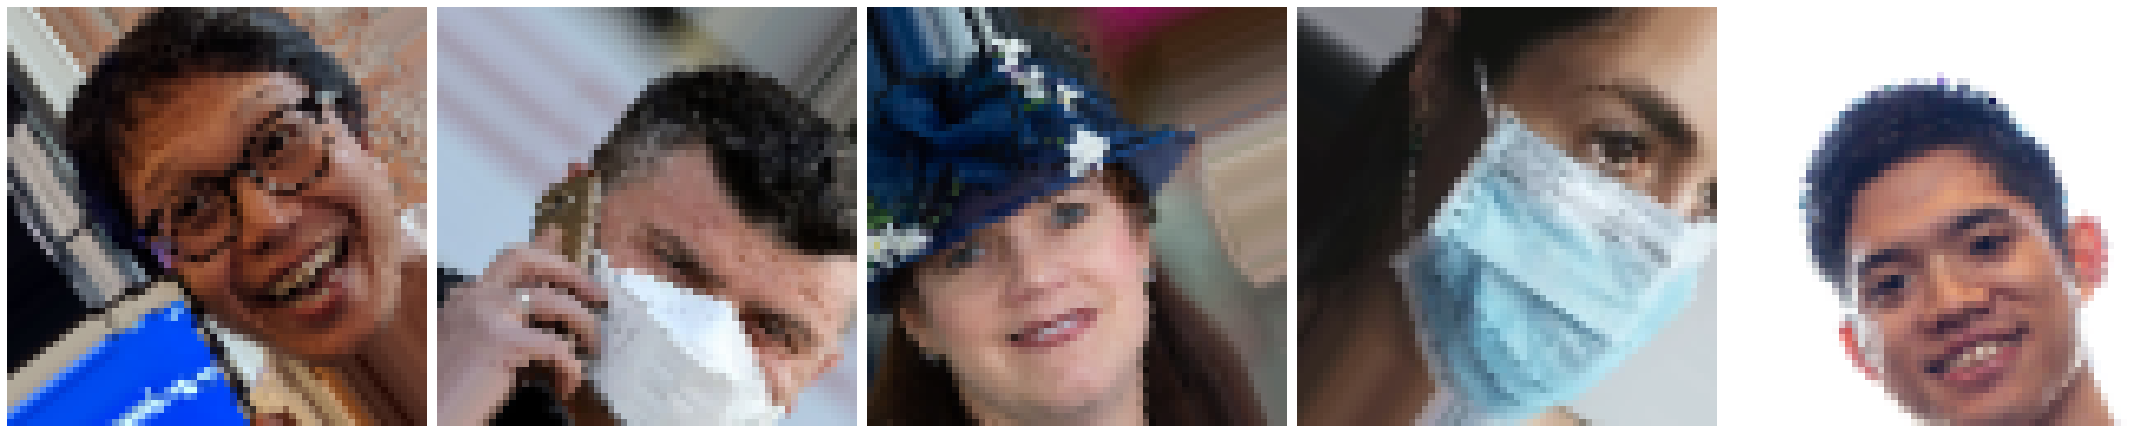

In [181]:
#visualize dataset
sample_training_image, _ = next(train_data_gen)

def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(30,30))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis("off")
  plt.tight_layout()
  plt.show()

plotImages(sample_training_image[:5])

In [182]:
# model

convolutional_block = convolutional_blocks = [
  Conv2D(32,(3,3), activation="relu", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  MaxPooling2D(pool_size=(2,2)),
  Conv2D(32, (3,3), activation="relu"),
  MaxPooling2D(pool_size=(2,2)),
  Flatten(),
  Dense(128, activation="relu"),
  Dense(1, activation="sigmoid")
]

model = Sequential(convolutional_blocks)


# pre_trained_model = tf.keras.applications.MobileNetV2(input_shape=[224,224,3], include_top=False, weights="imagenet")
# for layer in pre_trained_model.layers:
#   layer.traineable = False

# last_layer = pre_trained_model.get_layer("block_7_add")
# last_output = last_layer.output

# x = Flatten()(last_output)
# x = Dense(1024, activation="relu")(x)
# x = Dropout(0.3)(x)
# x = Dense(1, activation="sigmoid")(x)

# model = Model(pre_trained_model.input, x)


In [183]:
## compile

model.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [184]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               802944    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                

In [185]:
# class myCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs={}):
#     if(logs.get('accuracy')>0.90):
#       print("\nReached 90% accuracy so cancelling training!")
#       self.model.stop_training = True

# callbacks = myCallback()

history = model.fit(
    train_data_gen,
    steps_per_epoch= total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps= total_val // batch_size,
    # callbacks=[callbacks]
)

Epoch 1/10
23/23 [==============================] - 31s 1s/step - loss: 0.6801 - accuracy: 0.5084 - val_loss: 0.5980 - val_accuracy: 0.6656
Epoch 2/10
23/23 [==============================] - 30s 1s/step - loss: 0.6176 - accuracy: 0.7409 - val_loss: 0.5303 - val_accuracy: 0.9219
Epoch 3/10
23/23 [==============================] - 30s 1s/step - loss: 0.5699 - accuracy: 0.8426 - val_loss: 0.5181 - val_accuracy: 0.9094
Epoch 4/10
23/23 [==============================] - 29s 1s/step - loss: 0.5521 - accuracy: 0.8747 - val_loss: 0.5130 - val_accuracy: 0.9250
Epoch 5/10
23/23 [==============================] - 29s 1s/step - loss: 0.5510 - accuracy: 0.8830 - val_loss: 0.5273 - val_accuracy: 0.9062
Epoch 6/10
23/23 [==============================] - 29s 1s/step - loss: 0.5554 - accuracy: 0.8607 - val_loss: 0.5122 - val_accuracy: 0.9281
Epoch 7/10
23/23 [==============================] - 29s 1s/step - loss: 0.5520 - accuracy: 0.8830 - val_loss: 0.5200 - val_accuracy: 0.9219
Epoch 8/10
23/23 [==

10 10 [0.5083565711975098, 0.7409470677375793, 0.8426184058189392, 0.8746517896652222, 0.8830083608627319, 0.8607242107391357, 0.8830083608627319, 0.8760445713996887, 0.8857938647270203, 0.8913649320602417]


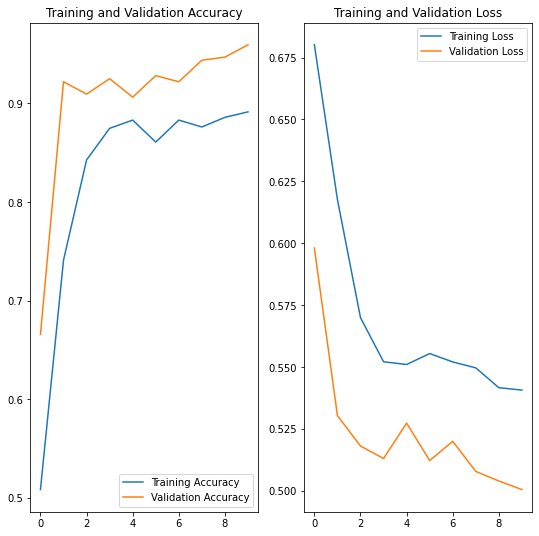

In [186]:
#plot loss & acc

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)
print(epochs, len(acc),acc)
plt.figure(figsize=(9, 9))
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [187]:
evaluate = model.evaluate(val_data_gen, steps=total_val/batch_size)
print(evaluate)

11/10 [==============================] - 10s 867ms/step - loss: 0.4977 - accuracy: 0.9571
[0.4976603090763092, 0.9571428298950195]


In [188]:

## Real testing on image
print("## Predicting image 1")
img_pred = image.load_img('/content/drive/My Drive/Mask_Datasets/Validation/Mask/99.PNG', target_size = (IMG_WIDTH, IMG_HEIGHT))
img_pred = image.img_to_array(img_pred)
img_pred = np.expand_dims(img_pred, axis = 0)
result = model.predict(img_pred)
print(result)
if result[0] < 0.5:
	prediction = "Mask"
else:
	prediction = "No mask"
print(prediction)



print("## Predicting image 2")
img_pred = image.load_img('/content/drive/My Drive/Mask_Datasets/Validation/No_mask/16012.png', target_size = (IMG_WIDTH, IMG_HEIGHT))
img_pred = image.img_to_array(img_pred)
img_pred = np.expand_dims(img_pred, axis = 0)
result = model.predict(img_pred)
print(result)
if result[0] < 0.5:
	prediction = "Mask"
else:
	prediction = "No mask"
print(prediction)


## Predicting image 1
[[0.]]
Mask
## Predicting image 2
[[1.]]
No mask


### Saving the model

In [189]:
tfjs_target_dir = "/content/drive/My Drive/Mask_Datasets/Model1/"

In [190]:
import tensorflowjs as tfjs

In [191]:
tfjs.converters.save_keras_model(model, tfjs_target_dir)

/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/keras_h5_conversion.py:122: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)
